# XGBoost Models | with feature selection

**XGBRegressor**

Josie Donnelly

*Last updated 10.31.22*

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from statistics import mode
from datetime import datetime
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor


## Preprocessing

In [2]:
# load merged dataset
path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
file = 'float_loc_data_new_vars2.csv'

date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df_orig = pd.read_csv(path + file, parse_dates=['date'], date_parser=date_parser)
df_orig


,float,latitude,longitude,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA,...,sat_pic,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,6.958747e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,6.958747e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,6.964993e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,7.164887e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,7.155517e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33210612,7901001,17.330,-23.271,28,2022-05-23 11:34:00,968,34.916109,6.358057,0.000216,-3.686869e-05,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093
33210613,7901001,17.330,-23.271,28,2022-05-23 11:34:00,975,34.916280,6.346782,0.000216,-1.843434e-05,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093
33210614,7901001,17.330,-23.271,28,2022-05-23 11:34:00,977,34.916280,6.346782,0.000216,2.543358e-18,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093
33210615,7901001,17.330,-23.271,28,2022-05-23 11:34:00,982,34.916280,6.346782,0.000216,2.543358e-18,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093


In [11]:
df_orig.columns


Index(['float', 'latitude', 'longitude', 'cycleNumber', 'date', 'PRES', 'PSAL',
       'TEMP', 'BBP700', 'CHLA', 'short_date', 'sat_chl', 'sat_ipar',
       'sat_sst', 'sat_poc', 'sat_bbp_443', 'sat_a_678', 'sat_kd_490',
       'sat_nflh', 'sat_pic', 'sat_Rrs_678', 'sat_aph_443', 'sat_par',
       'sat_angstrom', 'sat_bb_678', 'sat_adg_443', 'sat_aot_869', 'sat_adg_s',
       'sat_bbp_s'],
      dtype='object')

In [70]:
df = df_orig[['float', 'latitude', 'longitude', 'date', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443', 'PRES', 'TEMP', 'CHLA']]
# sat_chl: chlorophyll-a concentration
# sat_sst: sea surface temperature
# sat_pic: calcite concentration
# sat_par: photosynthetically available radiation
# sat_aph_443: absorption due to phytoplankton (443 nm)

# add a column for the day of the year in radians
df.insert(loc=list(df.columns).index('date'), column='day_of_year_rad', value=[(int(d.strftime('%j'))*np.pi)/182.625 for d in df['date']])

# consider only the observations for which the target CHLA is available
df = df[~df['CHLA'].isna()].reset_index(drop=True)
df


,float,latitude,longitude,day_of_year_rad,date,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,TEMP,CHLA
0,1902303,49.236,-14.742,2.167505,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,3,12.378333,6.958747e-01
1,1902303,49.236,-14.742,2.167505,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,4,12.378333,6.958747e-01
2,1902303,49.236,-14.742,2.167505,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,6,12.378667,6.964993e-01
3,1902303,49.236,-14.742,2.167505,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,8,12.379000,7.164887e-01
4,1902303,49.236,-14.742,2.167505,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,10,12.379000,7.155517e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33076991,7901001,17.330,-23.271,2.459947,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,968,6.358057,-3.686869e-05
33076992,7901001,17.330,-23.271,2.459947,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,975,6.346782,-1.843434e-05
33076993,7901001,17.330,-23.271,2.459947,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,977,6.346782,2.543358e-18
33076994,7901001,17.330,-23.271,2.459947,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,982,6.346782,2.543358e-18


In [71]:
# ensure the rows of the dataframe are unique
df.shape[0] == df.drop_duplicates().shape[0]


True

## Define functions

In [72]:
# function to join CHLA data onto satellite information based on lat, long, and date
def get_data_by_depth(df, depth_bin):
       
    data_df = df[df['depth_bin'] == depth_bin]
    data_df = data_df.drop(columns=['float', 'date', 'PRES', 'depth_bin', 'TEMP'])
    
    return data_df


In [73]:
def split_and_standardize(data_df, test_size=0.2):
        
    X = data_df.drop(columns='CHLA')
    y = data_df['CHLA']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    X_train._is_copy = None
    X_test._is_copy = None
    
    # perform (training) mean inputation for missing values by column
    for c in X_train.columns:
        c_train_mean = np.mean(X_train[c])
        X_train[c].fillna(value=c_train_mean, inplace=True)
        X_test[c].fillna(value=c_train_mean, inplace=True)
      
    ss = StandardScaler()
    X_train[X_train.columns] = ss.fit_transform(X_train[X_train.columns])
    X_test[X_test.columns] = ss.transform(X_test[X_test.columns])
    
    return X_train, X_test, y_train, y_test
          

In [74]:
# function to cross validate and display scores
def train_and_get_scores(model, X, y, metrics, n_splits=5, verbose=0):
    
    scores = cross_validate(model, X, y, cv=n_splits,
                           scoring=metrics,
                           return_estimator=True,
                           return_train_score=True)
    
    vals = []
    for group in ['train', 'test']:
        for metric in metrics:
            if metric == 'neg_mean_squared_error':
                val = np.mean(-scores[f'{group}_{metric}'])
                metric = 'MSE'
            else:
                val = np.mean(scores[f'{group}_{metric}'])
            
            if verbose > 0:
                if group == 'test':
                    print(f'\tAvg val {metric}: {val:.4f}', end='')
                else:
                    print(f'\tAvg {group} {metric}: {val:.4f}', end='')
                
            vals.append(val)
    
    if verbose > 0:
        print()
    
    return vals


In [75]:
# function to fit model on training and testing data
# returns predictions on train and test data
def fit_predict(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    return train_preds, test_preds
    

In [76]:
# display the results of the regression as scatter plots: predicted value vs. target
def plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, plt_n_cols=5):  
    plt.subplot((len(bins)//plt_n_cols)+1,plt_n_cols,depth_idx+1)
    plt.scatter(y_train, train_preds, label=f'train (r2 = {r2_score(y_train, train_preds):.2f})', alpha=0.7)
    plt.scatter(y_test, test_preds, label=f'test (r2 = {r2_score(y_test, test_preds):.2f})', alpha=0.7)
    plt.title(f'{bins[depth_idx]}m to {bins[depth_idx+1]}m', fontsize='x-large')
    plt.xlabel('true CHLA')
    plt.ylabel('predicted CHLA')
    plt.legend()
    

## XGB regressor at varying depths

In [81]:
# define depth bins
try:
    df = df.drop(columns='depth_bin')
except:
    pass

max_depth = max(df['PRES'])
interval = 20
bins = np.arange(0, max_depth + interval, interval)
bins[-2] = bins[-1]
bins = bins[:-1]     # absporbing the deepest bin into the second deepest bin because there are so few observations

depth_bins = pd.cut(df['PRES'], bins=bins, right=True, labels=False, retbins=False, include_lowest=True)

df.insert(loc=list(df.columns).index('PRES')+1, column='depth_bin', value=depth_bins)
df


,float,latitude,longitude,day_of_year_rad,date,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,depth_bin,TEMP,CHLA
0,1902303,49.236,-14.742,2.167505,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,3,0,12.378333,6.958747e-01
1,1902303,49.236,-14.742,2.167505,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,4,0,12.378333,6.958747e-01
2,1902303,49.236,-14.742,2.167505,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,6,0,12.378667,6.964993e-01
3,1902303,49.236,-14.742,2.167505,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,8,0,12.379000,7.164887e-01
4,1902303,49.236,-14.742,2.167505,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,10,0,12.379000,7.155517e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33076991,7901001,17.330,-23.271,2.459947,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,968,48,6.358057,-3.686869e-05
33076992,7901001,17.330,-23.271,2.459947,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,975,48,6.346782,-1.843434e-05
33076993,7901001,17.330,-23.271,2.459947,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,977,48,6.346782,2.543358e-18
33076994,7901001,17.330,-23.271,2.459947,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,982,49,6.346782,2.543358e-18


In [82]:
# initialize dataframe to store results
# results_df = pd.DataFrame(columns=['depth_idx', 'depth_interval', 'num_observations', 'avg_cv_train_mse', 'avg_cv_train_r2', 'avg_cv_test_mse', 'avg_cv_test_r2', 'final_train_mse', 'final_train_r2', 'final_test_mse', 'final_test_r2'])
results_df = pd.DataFrame(columns=['depth_idx', 'depth_interval', 'num_observations', 'train_mse', 'train_r2', 'test_mse', 'test_r2'])


DEPTH 0: 0m to 20m
	Num train samples: 750281  |  Num test samples: 187571
	Train MSE: 0.0292  |  Train r2: 0.9407
	Test MSE: 0.0311   |  Test r2: 0.9360

DEPTH 1: 20m to 40m
	Num train samples: 760647  |  Num test samples: 190162
	Train MSE: 0.0560  |  Train r2: 0.8801
	Test MSE: 0.0608   |  Test r2: 0.8728

DEPTH 2: 40m to 60m
	Num train samples: 760504  |  Num test samples: 190127
	Train MSE: 0.0411  |  Train r2: 0.8393
	Test MSE: 0.0431   |  Test r2: 0.8303

DEPTH 3: 60m to 80m
	Num train samples: 759695  |  Num test samples: 189924
	Train MSE: 0.0217  |  Train r2: 0.8265
	Test MSE: 0.0229   |  Test r2: 0.8162

DEPTH 4: 80m to 100m
	Num train samples: 756817  |  Num test samples: 189205
	Train MSE: 0.0107  |  Train r2: 0.8140
	Test MSE: 0.0113   |  Test r2: 0.8025

DEPTH 5: 100m to 120m
	Num train samples: 730854  |  Num test samples: 182714
	Train MSE: 0.0056  |  Train r2: 0.7824
	Test MSE: 0.0059   |  Test r2: 0.7657

DEPTH 6: 120m to 140m
	Num train samples: 731310  |  Num test 

/var/folders/9p/2w26l_q932bbph2rfc83837c0000gn/T/ipykernel_35863/350038996.py:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


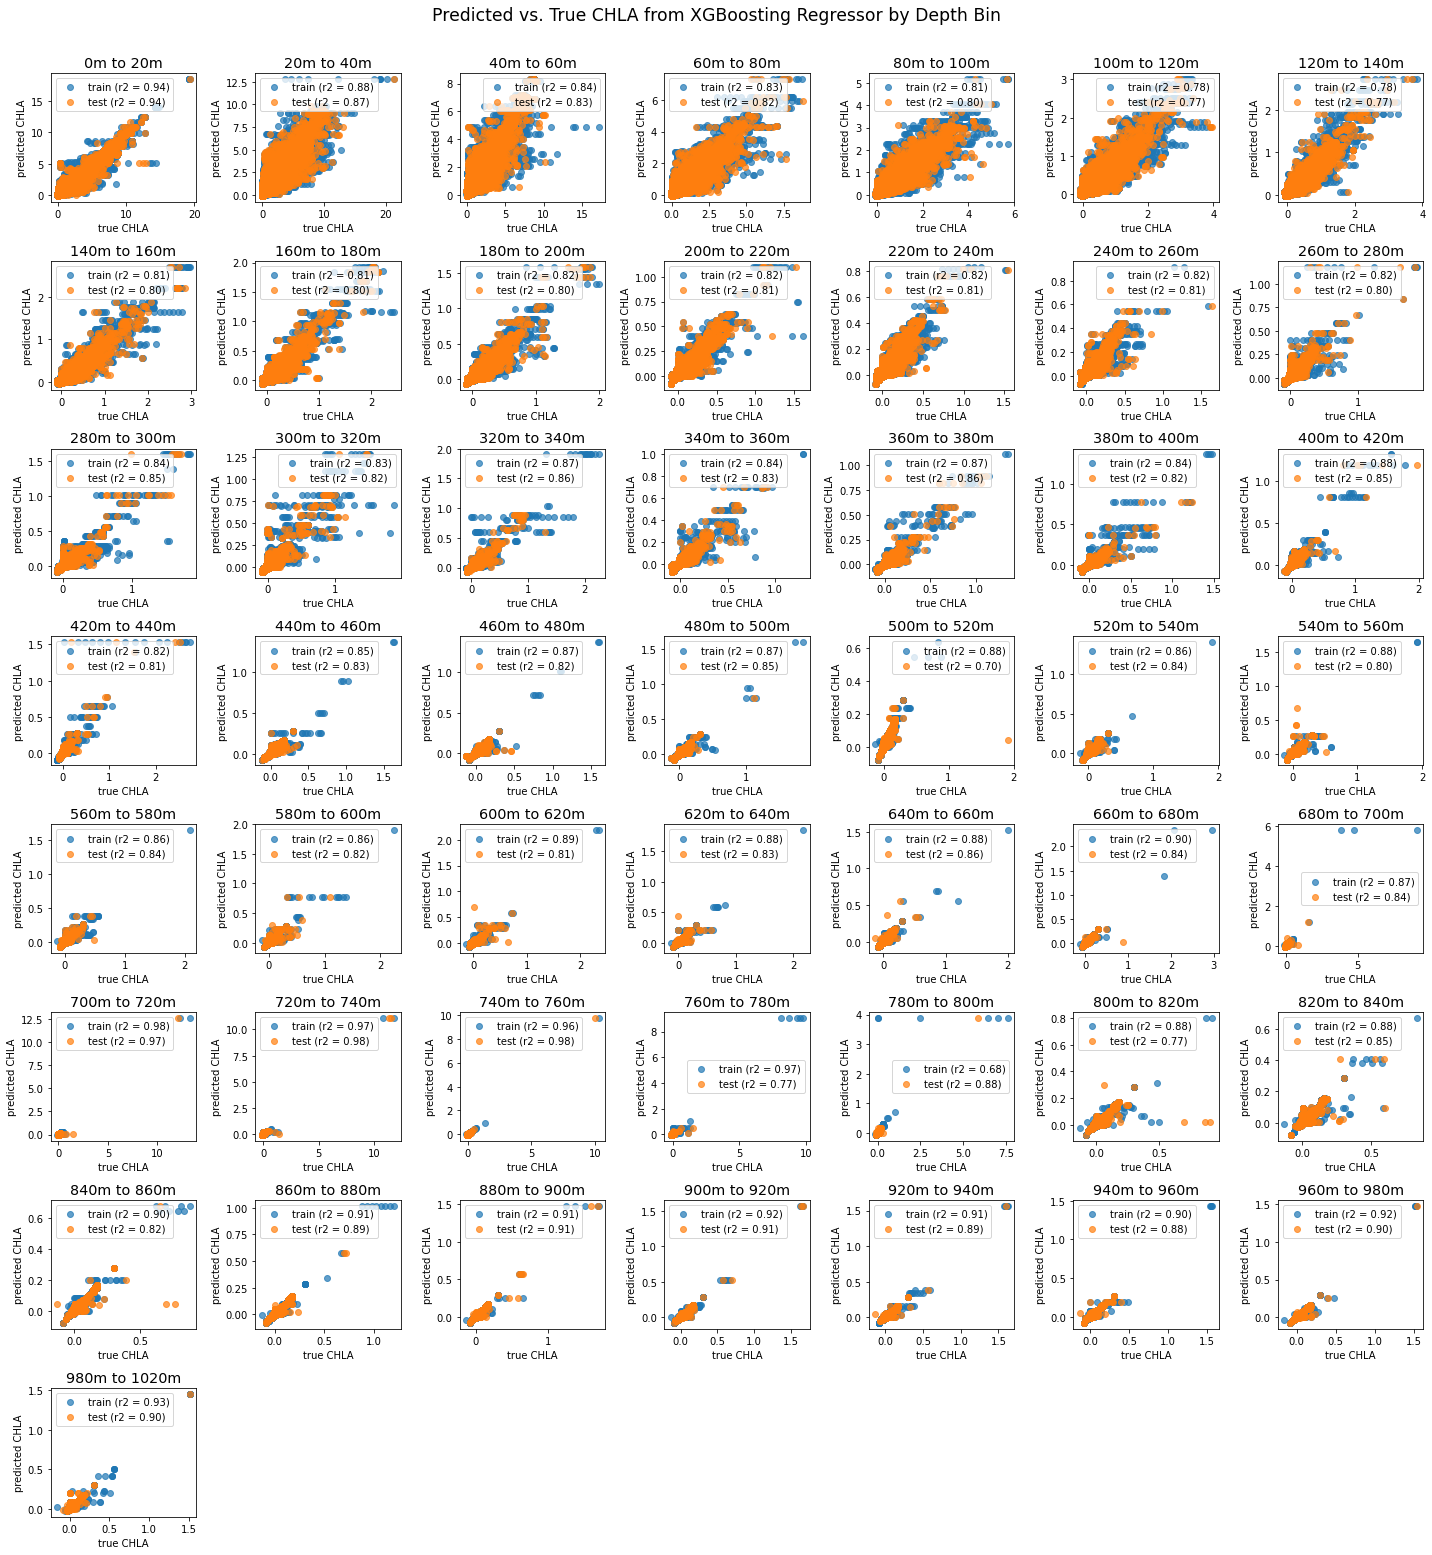

In [83]:
# fit a gradient booting regression model for the ocean at different depth bins
verbose = 1
plt.figure(figsize=(20,22))
plt.suptitle('Predicted vs. True CHLA from XGBoosting Regressor by Depth Bin\n\n', fontsize='xx-large')

for depth_idx in range(len(bins)-1):
    
    if verbose > 0:
        print(f'DEPTH {depth_idx}: {bins[depth_idx]}m to {bins[depth_idx+1]}m')
    
    # obtain data for this bin
    data_df = get_data_by_depth(df, depth_bin=depth_idx)

    # train-test-split and standardization
    X_train, X_test, y_train, y_test = split_and_standardize(data_df, test_size=0.2)
        
    if verbose > 0:
        print(f'\tNum train samples: {X_train.shape[0]}', end='  |  ')
        print(f'Num test samples: {X_test.shape[0]}')
    
    # train, predict, and get scores for XGBoosting regressor
    xgbr = XGBRegressor(n_estimators=100, max_depth=8, colsample_bytree=0.9)     # grow_policy = 'depthwise' or 'lossguide'
#     scores = train_and_get_scores(xgbr, X_train, y_train, metrics=['neg_mean_squared_error', 'r2'], n_splits=3, verbose=verbose)
    train_preds, test_preds = fit_predict(xgbr, X_train, y_train, X_test, y_test)
    
    if verbose > 0: 
        print(f'\tTrain MSE: {mean_squared_error(y_train, train_preds):.4f}', end='  |  ')
        print(f'Train r2: {r2_score(y_train, train_preds):.4f}')
        print(f'\tTest MSE: {mean_squared_error(y_test, test_preds):.4f}', end='   |  ')
        print(f'Test r2: {r2_score(y_test, test_preds):.4f}')
    
    # plot predictions vs. true values
    plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, plt_n_cols=7)
    
    # add scores to results dataframe
#     results_df.loc[results_df.shape[0]] = [depth_idx, (bins[depth_idx], bins[depth_idx+1]), data_df.shape[0]] + scores + [mean_squared_error(y_train, train_preds), r2_score(y_train, train_preds), mean_squared_error(y_test, test_preds), r2_score(y_test, test_preds)]
    results_df.loc[results_df.shape[0]] = [depth_idx, (bins[depth_idx], bins[depth_idx+1]), data_df.shape[0]] + [mean_squared_error(y_train, train_preds), r2_score(y_train, train_preds), mean_squared_error(y_test, test_preds), r2_score(y_test, test_preds)]

    if verbose > 0:
        print()
        
plt.tight_layout()
plt.show()


## Display XGBoost regressor results

In [84]:
# display the dataframe of results
print(f'Average train r2: {np.mean(results_df["train_r2"])}')
print(f'Average test r2: {np.mean(results_df["test_r2"])}')
results_df


Average train r2: 0.8668015275749164
Average test r2: 0.8420814650810943


,depth_idx,depth_interval,num_observations,train_mse,train_r2,test_mse,test_r2
0,0,"(0, 20)",937852,0.029216,0.940682,0.031082,0.935988
1,1,"(20, 40)",950809,0.056022,0.880130,0.060828,0.872764
2,2,"(40, 60)",950631,0.041070,0.839280,0.043135,0.830289
3,3,"(60, 80)",949619,0.021664,0.826544,0.022858,0.816177
4,4,"(80, 100)",946022,0.010735,0.814008,0.011309,0.802529
5,5,"(100, 120)",913568,0.005563,0.782370,0.005902,0.765662
6,6,"(120, 140)",914138,0.002955,0.778438,0.003137,0.766858
7,7,"(140, 160)",911918,0.001604,0.808461,0.001678,0.797448
8,8,"(160, 180)",911336,0.000949,0.808507,0.001001,0.796610
9,9,"(180, 200)",911642,0.000521,0.815037,0.000548,0.801302


In [85]:
max(results_df['test_r2'])

0.983762510785072

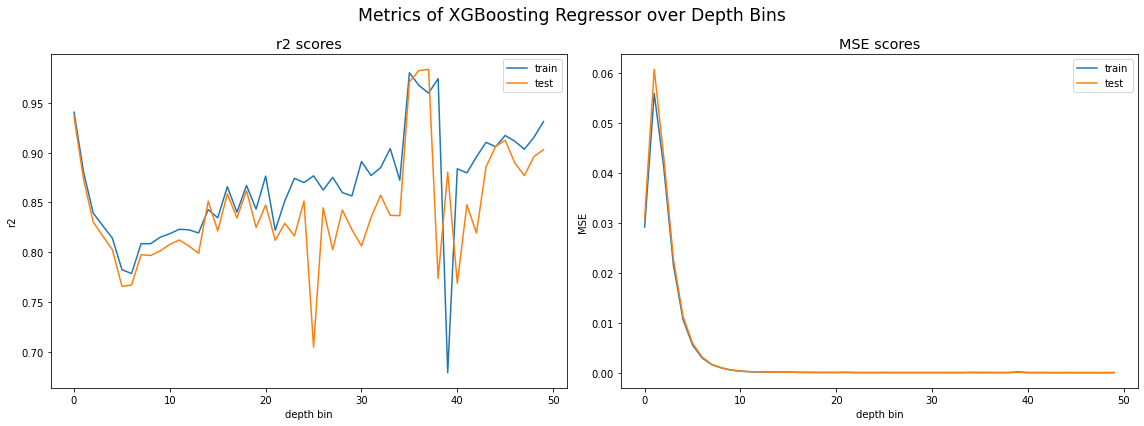

In [86]:
# plot metrics for different depths
plt.figure(figsize=(16,6))
plt.suptitle('Metrics of XGBoosting Regressor over Depth Bins', fontsize='xx-large')

plt.subplot(1,2,1)
plt.plot(range(results_df.shape[0]), results_df['train_r2'], label='train')
plt.plot(range(results_df.shape[0]), results_df['test_r2'], label='test')
plt.title('r2 scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('r2')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(results_df.shape[0]), results_df['train_mse'], label='train')
plt.plot(range(results_df.shape[0]), results_df['test_mse'], label='test')
plt.title('MSE scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [87]:
results_df.to_csv('results_xgb_feature_selection_ejd.csv', index=False)


## XGB regressor at surface depths (top 20m at smaller intervals)

In [74]:
# bin the observations into depth intervals
float_loc_df_20 = float_loc_df[float_loc_df['PRES'] <= 20]
try:
    float_loc_df_20.drop(columns='depth_bin', inplace=True)
except:
    pass

max_depth = max(float_loc_df_20['PRES'])
interval = 2
bins = np.arange(0, max_depth + interval, interval)
# bins[-1] = max_depth

depth_bins = pd.cut(float_loc_df_20['PRES'], bins=bins, right=True, labels=False, retbins=False, include_lowest=True)

float_loc_df_20.insert(loc=list(float_loc_df_20.columns).index('PRES'), column='depth_bin', value=depth_bins)
float_loc_df_20


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,float,latitude,longitude,date,date_str,depth_bin,PRES,BBP700,CHLA
0,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,1,3,0.001788,0.695875
1,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,1,4,0.001788,0.695875
2,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,2,6,0.001788,0.696499
3,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,3,8,0.001789,0.716489
4,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,4,10,0.001790,0.715552
...,...,...,...,...,...,...,...,...,...
33056597,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,7,16,0.000527,0.040150
33056598,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,8,17,0.000534,0.040337
33056599,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,8,18,0.000541,0.040524
33056600,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,9,19,0.000541,0.040524


In [75]:
# initialize dataframe to store results
results_df_20 = pd.DataFrame(columns=['depth_idx', 'depth_interval', 'num_observations', 'avg_cv_train_mse', 'avg_cv_train_r2', 'avg_cv_test_mse', 'avg_cv_test_r2', 'final_train_mse', 'final_train_r2', 'final_test_mse', 'final_test_r2'])


DEPTH 0: 0m to 2m
	Num train samples: 24711  |  Num test samples: 6178
	Avg train MSE: 0.0213	Avg train r2: 0.9589	Avg val MSE: 0.1929	Avg val r2: 0.6277
	Final test MSE: 0.1910  |  Final test r2: 0.5705

DEPTH 1: 2m to 4m
	Num train samples: 29955  |  Num test samples: 7489
	Avg train MSE: 0.0244	Avg train r2: 0.9522	Avg val MSE: 0.2009	Avg val r2: 0.6069
	Final test MSE: 0.1674  |  Final test r2: 0.6401

DEPTH 2: 4m to 6m
	Num train samples: 37746  |  Num test samples: 9437
	Avg train MSE: 0.0293	Avg train r2: 0.9458	Avg val MSE: 0.2180	Avg val r2: 0.5959
	Final test MSE: 0.1811  |  Final test r2: 0.5943

DEPTH 3: 6m to 8m
	Num train samples: 37851  |  Num test samples: 9463
	Avg train MSE: 0.0288	Avg train r2: 0.9446	Avg val MSE: 0.2163	Avg val r2: 0.5839
	Final test MSE: 0.1945  |  Final test r2: 0.6341

DEPTH 4: 8m to 10m
	Num train samples: 37489  |  Num test samples: 9373
	Avg train MSE: 0.0295	Avg train r2: 0.9444	Avg val MSE: 0.2174	Avg val r2: 0.5894
	Final test MSE: 0.1852  

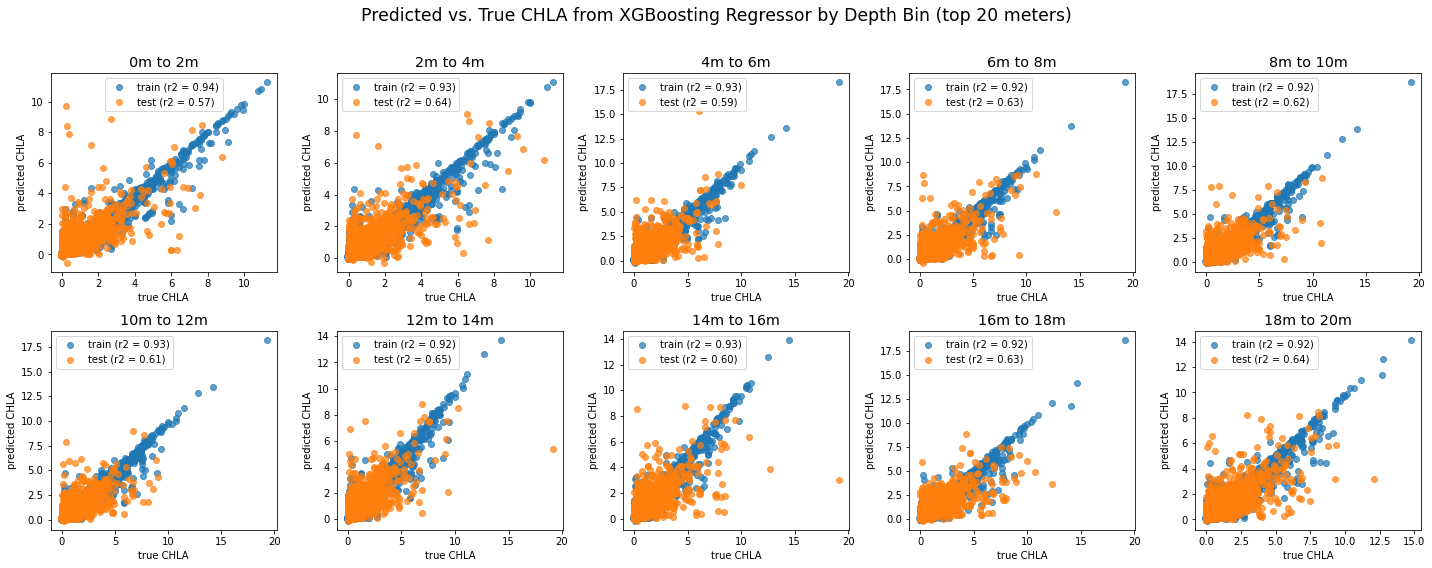

In [76]:
# fit a gradient booting regression model for the surface 20m
verbose = 1
plt.figure(figsize=(20,8))
plt.suptitle('Predicted vs. True CHLA from XGBoosting Regressor by Depth Bin (top 20 meters)\n', fontsize='xx-large')

for depth_idx in range(len(bins)-1):
    
    if verbose > 0:
        print(f'DEPTH {depth_idx}: {bins[depth_idx]}m to {bins[depth_idx+1]}m')
    
    # obtain data for this bin
    data_df = get_data_by_depth(sat_df, float_loc_df_20, depth_bin=depth_idx)
    
    # train-test-split and standardization
    X_train, X_test, y_train, y_test = split_and_standardize(data_df, test_size=0.2)

    if verbose > 0:
        print(f'\tNum train samples: {X_train.shape[0]}', end='  |  ')
        print(f'Num test samples: {X_test.shape[0]}')
    
    # train, predict, and get scores for XGBoosting regressor
    xgbr = XGBRegressor(n_estimators=100, max_depth=8, colsample_bytree=0.9)     # grow_policy = 'depthwise' or 'lossguide'
    scores = train_and_get_scores(xgbr, X_train, y_train, metrics=['neg_mean_squared_error', 'r2'], n_splits=3, verbose=verbose)
    train_preds, test_preds = fit_predict(xgbr, X_train, y_train, X_test, y_test)
    
    if verbose > 0:   
        print(f'\tFinal test MSE: {mean_squared_error(y_test, test_preds):.4f}', end='  |  ')
        print(f'Final test r2: {r2_score(y_test, test_preds):.4f}')
    
    # plot predictions vs. true values
    plot(depth_idx, bins, y_train, train_preds, y_test, test_preds)
    
    # add scores to results dataframe
    results_df_20.loc[results_df_20.shape[0]] = [depth_idx, (bins[depth_idx], bins[depth_idx+1]), data_df.shape[0]] + scores + [mean_squared_error(y_train, train_preds), r2_score(y_train, train_preds), mean_squared_error(y_test, test_preds), r2_score(y_test, test_preds)]
    
    if verbose > 0:
        print()
        
plt.tight_layout()
plt.show()


## Results: hyperparameter combinations


* n_estimators=100, max_depth=8, colsample_bytree=0.9
    * improved test r2 compared to wider depth intervals of the models spanning the whole ocean
    * MSE of train and test are not as disparate as with default XGBRegressor model
    * Average cv train r2: 0.89
    * Average final test r2: 0.51


## Display XGBoost regressor results

In [77]:
# display the dataframe od results
print(f'Average final train r2: {np.mean(results_df_20["final_train_r2"])}')
print(f'Average final test r2: {np.mean(results_df_20["final_test_r2"])}')
results_df_20


Average final train r2: 0.9268842969496799
Average final test r2: 0.6179092262102407


,depth_idx,depth_interval,num_observations,avg_cv_train_mse,avg_cv_train_r2,avg_cv_test_mse,avg_cv_test_r2,final_train_mse,final_train_r2,final_test_mse,final_test_r2
0,0,"(0, 2)",30889,0.021273,0.958937,0.192911,0.627743,0.030241,0.941614,0.190983,0.570545
1,1,"(2, 4)",37444,0.024436,0.952221,0.200915,0.606903,0.035406,0.930961,0.167388,0.640077
2,2,"(4, 6)",47183,0.029289,0.945776,0.218040,0.595908,0.040107,0.925780,0.181124,0.594267
3,3,"(6, 8)",47314,0.028771,0.944550,0.216291,0.583902,0.038952,0.924935,0.194511,0.634059
4,4,"(8, 10)",46862,0.029506,0.944429,0.217421,0.589408,0.042351,0.920473,0.185228,0.617229
5,5,"(10, 12)",45728,0.029075,0.947836,0.231332,0.587326,0.040015,0.928400,0.178782,0.608435
6,6,"(12, 14)",46884,0.030553,0.942760,0.218128,0.592760,0.041478,0.922428,0.188232,0.645034
7,7,"(14, 16)",45219,0.028646,0.946499,0.210734,0.606902,0.037728,0.929575,0.253274,0.600488
8,8,"(16, 18)",47288,0.031070,0.942423,0.211333,0.608940,0.043011,0.920359,0.213934,0.629051
9,9,"(18, 20)",45197,0.029998,0.945121,0.212896,0.610463,0.041406,0.924319,0.212674,0.639908


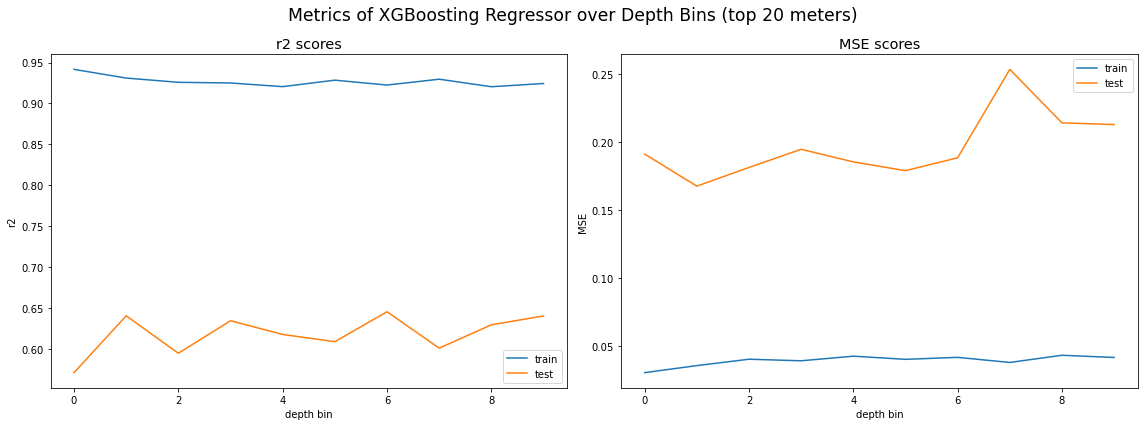

In [78]:
# plot metrics for different depths
plt.figure(figsize=(16,6))
plt.suptitle('Metrics of XGBoosting Regressor over Depth Bins (top 20 meters)', fontsize='xx-large')

plt.subplot(1,2,1)
plt.plot(range(results_df_20.shape[0]), results_df_20['final_train_r2'], label='train')
plt.plot(range(results_df_20.shape[0]), results_df_20['final_test_r2'], label='test')
plt.title('r2 scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('r2')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(results_df_20.shape[0]), results_df_20['final_train_mse'], label='train')
plt.plot(range(results_df_20.shape[0]), results_df_20['final_test_mse'], label='test')
plt.title('MSE scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [79]:
results_df_20.to_csv('results_xgb_different_depths_ejd_20.csv', index=False)
